In [1]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
import copy
from sklearn.gaussian_process.kernels import RBF
%matplotlib inline

In [2]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect
        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print('time for %s = %.4f' % (fname, t1-t0))
        print('')
        return result
    return f2

In [3]:
@timer
def make_2d_grf(kernel, noise=None, seed=42, npoints=40):
    """
    Function to generate a 1D gaussian random field for a 
    given scikit-learn kernel.
    
    :param kernel:  given sklearn kernel.
    :param noise:   float. Level of noise to add to the 
                    gaussian randomn field. (default: None)
    :param seed:    int. seed of the random process. (default: 42) 
    :param npoints: int. number of points to generate for the 
                    simulations.
    """
    # fixing the seed
    np.random.seed(seed)
    # generate random 2D coordinate
    x1 = np.random.uniform(-10,10, npoints)
    x2 = np.random.uniform(-10,10, npoints)
    x = np.array([x1, x2]).T
    # creating the correlation matrix / kernel 
    K = kernel.__call__(x)
    # generating gaussian random field
    y = np.random.multivariate_normal(np.zeros(npoints), K)
    if noise is not None:
        # adding noise
        y += np.random.normal(scale=noise, size=npoints)
        y_err = np.ones_like(y) * noise
        return x, y, y_err
    else:
        return x, y, None


In [4]:
# highly inspired by Gary Bernstein code to compute
# two-point correlation function of E and B mode 
# of vector field. But I guess this is one way
# to compute the two-pcf without writing a loop
# in python (loop are hiden in numpy)
@timer
def comp_pcf_numpy(x, y, kappa, kappa_err=None, binning=None):
    
    # Compute all indexes for pair computation,
    # distance (dr) and pair product (kk)

    ind = np.arange(len(x))

    i1, i2 = np.meshgrid(ind, ind)

    Filtre = (i1 > i2)
    i1 = i1.reshape(len(x)**2)
    i2 = i2.reshape(len(x)**2)
    Filtre = Filtre.reshape(len(x)**2)

    i1 = i1[Filtre]
    i2 = i2[Filtre]
    del Filtre
    
    # Compute distance for all pairs

    dy = y[i2]-y[i1]
    dx = x[i2]-x[i1]
    dr = np.sqrt(dx**2 + dy**2)

    # Compute pair product (weighted if error provided)
    
    if kappa_err is not None:
        weight = 1. / kappa_err**2
        ww = weight[i1] * weight[i2]
    else:
        ww = None

    kk = kappa[i1] * kappa[i2]
    if ww is not None:
        kk *= ww
        
    # compute 2-pcf

    counts = np.histogram(dr, bins=binning, weights=ww)[0]
    xi, dR = np.histogram(dr, bins=binning, weights=kk)
    xi /= counts

    # take center of the bin, not edge

    dR = copy.deepcopy(dR[:-1]) + (dR[1] - dR[0])/2.

    return xi, dR

In [5]:
@timer
def comp_pcf_treecorr(x, y, kappa, kappa_err=None, binning = np.linspace(0.1,3,10)):

    if kappa_err is None:
        weight = None
    else: 
        weight = 1. / kappa_err**2

    cat = treecorr.Catalog(x=x, y=y, k=kappa, w=weight)
    kk = treecorr.KKCorrelation(min_sep=binning[0], 
                                max_sep=binning[-1], 
                                nbins=len(binning),
                                bin_type='Linear')#,
                                #bin_slop=0)
    kk.process(cat)
    dR = kk.meanr
    xi = kk.xi
    return xi, dR

In [6]:
@timer
def comp_pcf_sid(x, y, kappa, kappa_err=None, binning=None):

    xs = np.array([x, y]).T
    #ys = np.array([kappa_x, kappa_y]).T
    ys = kappa

    # ``upper triangle'' indices for an (N, N) array
    ind = np.triu_indices(xs.shape[0])

    # seps has shape (N, N) up to ind
    # calculate the euclidean separation between each point in the field
    seps = np.asarray([np.sqrt(np.square(x[0]-xs[:,0])+np.square(x[1]-xs[:,1])) for x in xs])[ind]

    # pps0, pps1 have shape (N, N) up to ind
    # calculate the pair products of each component of each point of the
    # astrometric residuals
    #pps0 = np.outer(ys[:,0], ys[:,0])[ind]
    #pps1 = np.outer(ys[:,1], ys[:,1])[ind]
    pps = np.outer(kappa, kappa)[ind]

    # Use histograms to efficiently select pps according to sep
    # Inspired by Gary Bernstein via Pierre-Francois Leget
    counts, dr = np.histogram(seps, bins=binning)
    #xi0, _ = np.histogram(seps, bins=bins, weights=pps0)
    #xi1, _ = np.histogram(seps, bins=bins, weights=pps1)
    xi, _ = np.histogram(seps, bins=binning, weights=pps)

    dr = 0.5*(dr[:-1]+dr[1:])
    #xi0 /= counts
    #xi1 /= counts
    xi /= counts

    return xi, dr

time for make_2d_grf = 0.0940



(-10.88421188123008,
 10.795546398167922,
 -10.772126992199864,
 10.983233487528443)

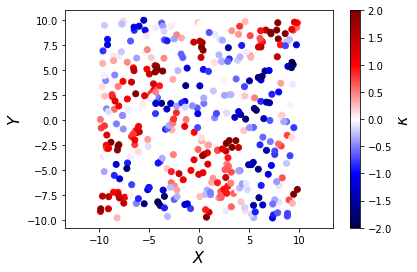

In [7]:
coord, kappa, kappa_err = make_2d_grf(RBF(1), seed=42, npoints=400)
plt.scatter(coord[:,0], coord[:,1], c=kappa, vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.xlabel('$X$', fontsize=16)
plt.ylabel('$Y$', fontsize=16)
cb = plt.colorbar()
cb.set_label('$\kappa$', fontsize=16)
plt.axis('equal')

In [8]:
binning = np.linspace(0.1,3,10)

# treecorr

xi_treecorr, dR_treecorr = comp_pcf_treecorr(coord[:,0], coord[:,1], kappa, kappa_err=None, binning=binning)

# numpy 
xi_numpy, dR_numpy = comp_pcf_numpy(coord[:,0], coord[:,1], kappa, kappa_err=None, binning=np.linspace(0.1,3,11))

# current class
xi_sid, dR_sid = comp_pcf_sid(coord[:,0], coord[:,1], kappa, kappa_err=None, binning=np.linspace(0.1,3,11))

time for comp_pcf_treecorr = 0.0394

time for comp_pcf_numpy = 0.0533

time for comp_pcf_sid = 0.0299



(0.0, 3.0)

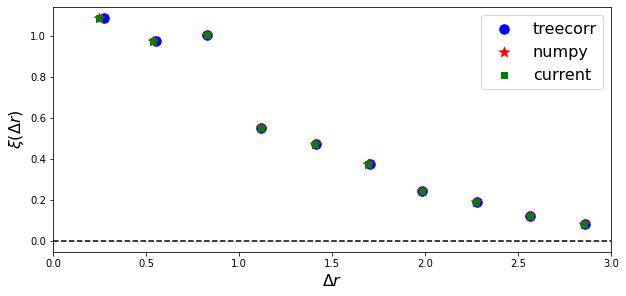

In [9]:
plt.figure(figsize=(10,4.5))
plt.scatter(dR_treecorr, xi_treecorr, c='b', s=90, label='treecorr')
plt.scatter(dR_numpy, xi_numpy,c='r', marker='*', s=110, label='numpy')
plt.scatter(dR_sid, xi_sid, c='g', marker='s', label='current')
plt.plot([0,3],[0,0], 'k--')
plt.legend(fontsize=16)
plt.xlabel('$\Delta r$', fontsize=16)
plt.ylabel('$\\xi(\Delta r)$', fontsize=16)
plt.xlim(0,3)